# SimMAtree

In [5]:
# Install simmatree directly from GitHub

# !pip install git+https://github.com/LostMa-ERC/simMAtree.git

# Issue on dependancies with colab! Run this 2 lines alternatively:
#!pip install git+https://github.com/LostMa-ERC/simMAtree.git --no-deps
#!pip install pandas numpy matplotlib seaborn pydantic click rich pyyaml

# Test installation
!simmatree-test

2025-06-03 15:35:25.337575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748964925.389455    5168 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748964925.407127    5168 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Looks good!


### Imports and Setup

In [6]:
import os
import tempfile
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import simmatree functions directly
from src.cli.config import Config
from src.cli.generate import generate
from src.cli.inference import inference
from src.cli.score import score

### Configuration example

In [34]:
# Define experiment configuration
config_dict = {
    'model': {
        'name': 'BirthDeath', # 'Yule' or 'BirthDeath' here
        'config': {
            'n_init': 500,
            'Nact': 1000,
            'Ninact': 1000,
            'max_pop': 100000
        }
    },
    'params': {
        'LDA': 0.3,
        'lda': 0.008,
        'gamma': 0.001,
        'mu': 0.0033
    },
    'inference': {
        'name': 'SBI',
        'config': {
            'method': 'NPE',
            'num_simulations': 50,
            'num_rounds': 2,
            'random_seed': 42,
            'num_samples': 100,
            'num_workers': 2,       # Reduced for Colab?
            'device': 'cpu'
        }
    }
}

# Create temporary directory for our experiment
temp_dir = "/content/"
config_file = os.path.join(temp_dir, 'BD_example.yml')

# Save configuration to YAML file
with open(config_file, 'w') as f:
    yaml.dump(config_dict, f, default_flow_style=False)

# Parse configuration using simmatree's Config class
config = Config(config_file)

print(f"Configuration saved to: {config_file}")


Configuration saved to: /content/BD_example.yml


### Data generation

In [35]:
# Generate synthetic witness data using the Python function directly
synthetic_data_file = os.path.join(temp_dir, 'data/synthetic_data.csv')

print("Generating synthetic witness data...")
print("This simulates the copying and transmission process of manuscripts.")

# Use the generate function directly
success = generate(
    data_path=synthetic_data_file,
    model=config.model,
    parameters=config.params,
    seed=42,
    show_params=False
)

print(f"\nGeneration successful: {success}")
print(f"Synthetic data saved to: {synthetic_data_file}")

# CLI equivalent:
print(f"\n💡 CLI equivalent: simmatree -c {config_file} generate -o {synthetic_data_file} --show-params")

Generating synthetic witness data...
This simulates the copying and transmission process of manuscripts.
Generating population...
Witness Number: 1961
Works Number: 264
Max Witnesses: 55
Number of 1: 35

Generation successful: True
Synthetic data saved to: /content/data/synthetic_data.csv

💡 CLI equivalent: simmatree -c /content/BD_example.yml generate -o /content/data/synthetic_data.csv --show-params


In [36]:
# Load and examine the synthetic data
df = pd.read_csv(synthetic_data_file, sep=';')

print("📊 Dataset Overview:")
print(f"Total witnesses: {len(df)}")
print(f"Unique texts: {df['text_ID'].nunique()}")
print(f"Data shape: {df.shape}")

print("\n🔍 First 10 rows:")
print(df.head(10))

# Analyze witness distribution
witness_counts = df.groupby('text_ID')['witness_ID'].count()

print(f"\n📈 Witness Distribution Statistics:")
print(f"Mean witnesses per text: {witness_counts.mean():.2f}")
print(f"Median witnesses per text: {witness_counts.median():.1f}")
print(f"Max witnesses for one text: {witness_counts.max()}")
print(f"Texts with only 1 witness: {(witness_counts == 1).sum()}")

📊 Dataset Overview:
Total witnesses: 1961
Unique texts: 264
Data shape: (1961, 2)

🔍 First 10 rows:
  witness_ID text_ID
0       W0-1      T0
1       W0-2      T0
2       W0-3      T0
3       W0-4      T0
4       W0-5      T0
5       W0-6      T0
6       W0-7      T0
7       W0-8      T0
8       W0-9      T0
9      W0-10      T0

📈 Witness Distribution Statistics:
Mean witnesses per text: 7.43
Median witnesses per text: 5.0
Max witnesses for one text: 55
Texts with only 1 witness: 35


<ipython-input-37-988a2fe7ce2a>:16: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[1].plot(x_values, y_values, 'o-', linestyle='--', marker='o',
<ipython-input-37-988a2fe7ce2a>:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  axes[1].plot(x_values, y_values, 'o-', linestyle='--', marker='o',


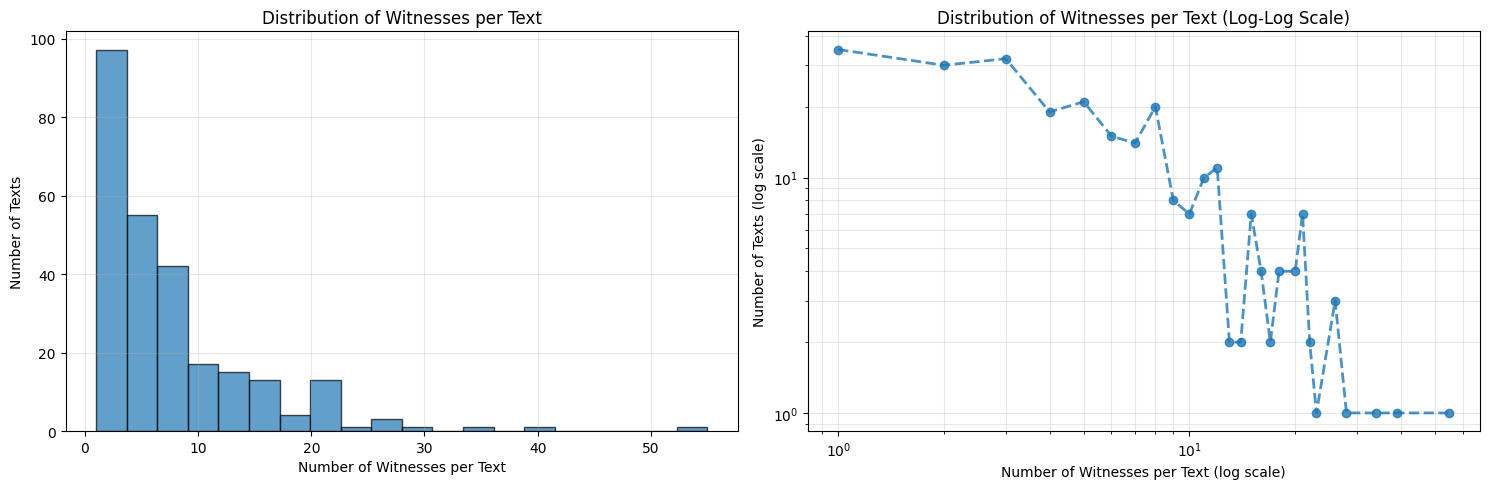

In [37]:
# Create visualization of witness distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of witness counts per text
axes[0].hist(witness_counts, bins=20, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Number of Witnesses per Text')
axes[0].set_ylabel('Number of Texts')
axes[0].set_title('Distribution of Witnesses per Text')
axes[0].grid(True, alpha=0.3)

# Log-scale version for better visualization
witness_freq = witness_counts.value_counts().sort_index()
x_values = witness_freq.index.values
y_values = witness_freq.values

axes[1].plot(x_values, y_values, 'o-', linestyle='--', marker='o',
             markersize=6, linewidth=2, alpha=0.8)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('Number of Witnesses per Text (log scale)')
axes[1].set_ylabel('Number of Texts (log scale)')
axes[1].set_title('Distribution of Witnesses per Text (Log-Log Scale)')
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()


## TODO : Comparaison avec Yule sur cette distribution ? (avec une autre config)

## Bayesian Inference

This may take a few minutes depending on the configuration.

In [ ]:
# Set up results directory
results_dir = Path(temp_dir) / 'inference_results'
results_dir.mkdir(exist_ok=True)

print("Running Bayesian inference...")
print("This will estimate the model parameters from the observed data.")

# Run inference using the Python function directly
inference_data = inference(
    csv_file=synthetic_data_file,
    model=config.model,
    backend=config.backend,
    dir=results_dir,
    csv_separator=';'
)

print(f"\n✅ Inference completed! Results saved to: {results_dir}")

# List generated files
result_files = list(results_dir.glob('*'))
print(f"\n📁 Generated files: {[f.name for f in result_files]}")

# CLI equivalent:
print(f"\n💡 CLI equivalent: simmatree -c {config_file} infer -i {synthetic_data_file} -o {results_dir}")


Running Bayesian inference...
This will estimate the model parameters from the observed data.
cpu


───────────────────────────────────────────────────── Dataset ─────────────────────────────────────────────────────

Data: /content/data/synthetic_data.csv

            Data observation            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ statistics                   ┃ value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Number of witnesses          │ 1961  │
│ Number of texts              │ 264   │
│ Max witnesses for 1 text     │ 55    │
│ Median witnesses per text    │ 5     │
│ Number of texts w/ 1 witness │ 35    │
└──────────────────────────────┴───────┘

──────────────────────────────────────────────── Running inference ────────────────────────────────────────────────

BirthDeath

Training device: cpu
Simulation device: cpu
Running simulations...
ROUND 1


  0%|          | 0/50 [00:00<?, ?it/s]